### Libraries and data loading

In [1]:
# import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import matplotlib.dates as mdates

%matplotlib inline

In [2]:
# check tensorflow version
print("tensorflow version:", tf.__version__)
# check available gpu
gpus =  tf.config.list_physical_devices('GPU')
print("available gpus:", gpus)
# limit the gpu usage, prevent it from allocating all gpu memory for a simple model
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# check number of cpus available
print("available cpus:", os.cpu_count())

tensorflow version: 2.4.1
available gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
available cpus: 128


In [3]:
# define the data location and load data
cwd = os.getcwd()
pardir = os.path.dirname(cwd)
data_folder = os.path.join(pardir,"data","data_nowcast")
data_path = os.path.join(data_folder, "nowcast_dataset.hdf5")

# !change model name for different models!
model_name = 'SUNSET_nowcast_2017_2019_data'
output_folder = os.path.join(pardir,"model_output", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

print("data_folder:", data_folder)
print("data_path:", data_path)
print("output_folder:", output_folder)

data_folder: /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/data/data_nowcast
data_path: /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/data/data_nowcast/nowcast_dataset.hdf5
output_folder: /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data


In [15]:
# generate handler for the hdf5 data
forecast_dataset = h5py.File(data_path, 'r')

# show structure of the hdf5 data
def get_all(name):
    if name!=None:
        print(forecast_dataset[name])
    
forecast_dataset.visit(get_all)

<HDF5 group "/test" (2 members)>
<HDF5 dataset "images_log": shape (14003, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (14003,), type "<f8">
<HDF5 group "/trainval" (2 members)>
<HDF5 dataset "images_log": shape (349372, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (349372,), type "<f8">


In [16]:
print('-'*50)
# get the input dimension for constructing the model
img_side_len = forecast_dataset['trainval']['images_log'].shape[1]
num_color_channel = forecast_dataset['trainval']['images_log'].shape[3]
image_input_dim = [img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

# load time stamps into the memory
times_trainval = np.load(os.path.join(data_folder,"times_trainval.npy"),allow_pickle=True)
print("times_trainval.shape:", times_trainval.shape)

# read through the dataset once in order to cache it but not store it into the memory
## read the data by batch
num_samples = len(times_trainval)
batch_size = num_samples//5
indices = np.arange(num_samples)
print('-'*50)
print('data reading start...')
for i in range(int(num_samples / batch_size) + 1):
    start_time = time.time()
    start_idx = (i * batch_size) % num_samples
    idxs = indices[start_idx:start_idx + batch_size]
    _ = forecast_dataset['trainval']['images_log'][idxs]
    _ = forecast_dataset['trainval']['pv_log'][idxs]
    end_time = time.time()
    print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
          .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))

# temporially close the dataset, will use "with" statement to open it when we use it
forecast_dataset.close()

--------------------------------------------------
image side length: 64
number of color channels: 3
input image dimension: [64, 64, 3]
times_trainval.shape: (349372,)
--------------------------------------------------
data reading start...
batch 1 samples: 0 to 69873, 20.00% finished, processing time 1.64s
batch 2 samples: 69874 to 139747, 40.00% finished, processing time 1.68s
batch 3 samples: 139748 to 209621, 60.00% finished, processing time 1.60s
batch 4 samples: 209622 to 279495, 80.00% finished, processing time 1.68s
batch 5 samples: 279496 to 349369, 100.00% finished, processing time 1.59s
batch 6 samples: 349370 to 349371, 100.00% finished, processing time 0.00s


### Input data pipeline helper functions

In [17]:
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):
    
    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [18]:
# a cross validation generator function for spliting the dayblock shuffled indices into training and validation
def cv_split(split_data, fold_index, num_fold):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices
    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data)
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[int(fold_index / num_fold * num_samples):int((fold_index + 1) / num_fold * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    np.random.seed(fold_index)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train,data_val

In [19]:
# a mapping function from the indices to the corresponding features and labels 
def data_loader(hdf5_data_path,sample_idx,batch_size=256):
    '''
    input:
    hdf5_data_path: path to hdf5 data file
    sample_idx: 
        for training and validation:
            dayblock shuffled indices with cross-validation split into training and validation
            either training or validation indices will be input
        for testing: the indices are not shuffled
    is_trainval: a flag, True for trainig and validation
    output:
    dataset: dataset for training, validation
    '''

    def mapping_func_py(hdf5_data_path,sample_idx):
        '''
        mapping indices to corresponding images and pviance data in hdf5 (python expression)
        '''
        # convert EagerTensor to str or numpy array
        hdf5_data_path = hdf5_data_path.numpy().decode() 
        # sort the sample indices as hdf5 requires increasing order index for data retrieval
        sample_idx = sorted(sample_idx.numpy())

        with h5py.File(hdf5_data_path,'r') as f:

            # read in the data
            images_log = f['trainval']['images_log'][sample_idx]
            pv_log = f['trainval']['pv_log'][sample_idx]

            # normalize image data to [0,1]
            images_log = tf.image.convert_image_dtype(images_log, tf.float32)
            
            # convert pv data to tf.tensor
            pv_log = tf.convert_to_tensor(pv_log, dtype=tf.float32)
            
            return images_log, pv_log

    def mapping_func_tf(hdf5_data_path,sample_idx):
        '''
        a wrapper mapping function to get the nested data structure 
        the output type of tf.py_function cannot be a nested sequence when using a tf.py_function with the tf.data API
        '''
        images_log, pv_log = tf.py_function(func=mapping_func_py,
                                                           inp=[hdf5_data_path, sample_idx], 
                                                           Tout=(tf.float32, tf.float32))
        return images_log, pv_log
    
    
    # create the indices dataset
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_idx)
    # shuffle and batch the indices
    idx_ds = idx_ds.shuffle(buffer_size = idx_ds.cardinality().numpy(),seed=0)
    idx_ds = idx_ds.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)
    
    # indices dataset mapping to images and pviance data
    # returning dataset with the following nested structure: (images_log, pv_log), pv_pred
    dataset = idx_ds.map(lambda x: mapping_func_tf(hdf5_data_path,x),
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

### Model architecture

In [7]:
# define model characteristics
num_filters = 24
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 256
learning_rate = 3e-06

In [25]:
# define the model architecture using tf.keras API
def sunset_model():
    ## input
    ### input image logs with shape (64,64,24)
    x_in = keras.Input(shape=image_input_dim)

    ## 1st convolution block
    x = keras.layers.Conv2D(num_filters,kernel_size,padding="same",activation='relu')(x_in)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = keras.layers.Conv2D(num_filters*2,kernel_size,padding="same",activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## two fully connected nets
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = keras.layers.Dense(units=1)(x)

    # construct the model
    model = keras.Model(inputs=x_in,outputs=y_out)

    return model

# show model architecture
sunset_model().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 24)        672       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 24)        96        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 48)        10416     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 48)        0   

### Model training and validation

Repetition 1 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 39.3762 - val_loss: 7.4163

Epoch 00001: val_loss improved from inf to 7.41635, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 7.6969 - val_loss: 6.1658

Epoch 00002: val_loss improved from 7.41635 to 6.16576, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 5.9467 - val_loss: 5.5190

Epoch 00003: val_loss improved from 6.16576 to 5.51895, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition

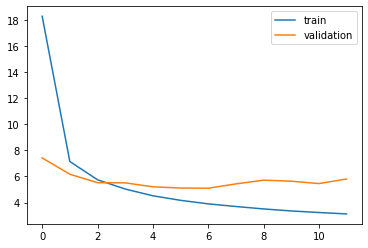

Repetition 2 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 39.9482 - val_loss: 4.5541

Epoch 00001: val_loss improved from inf to 4.55410, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_2/best_model_repitition_2.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 7.9326 - val_loss: 3.4410

Epoch 00002: val_loss improved from 4.55410 to 3.44098, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_2/best_model_repitition_2.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 6.1368 - val_loss: 3.0849

Epoch 00003: val_loss improved from 3.44098 to 3.08488, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition

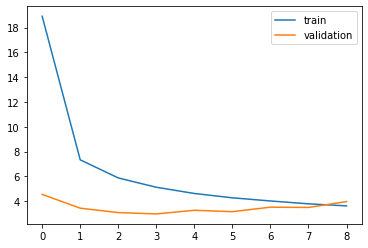

Repetition 3 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 39.8770 - val_loss: 6.9905

Epoch 00001: val_loss improved from inf to 6.99047, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_3/best_model_repitition_3.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 7.7540 - val_loss: 5.2394

Epoch 00002: val_loss improved from 6.99047 to 5.23945, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_3/best_model_repitition_3.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 6.0283 - val_loss: 4.6603

Epoch 00003: val_loss improved from 5.23945 to 4.66034, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition

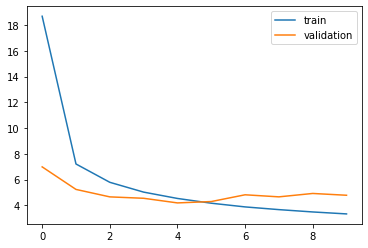

Repetition 4 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 38.5373 - val_loss: 6.2797

Epoch 00001: val_loss improved from inf to 6.27969, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_4/best_model_repitition_4.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 7.5834 - val_loss: 5.3308

Epoch 00002: val_loss improved from 6.27969 to 5.33080, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_4/best_model_repitition_4.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 5.9124 - val_loss: 4.9268

Epoch 00003: val_loss improved from 5.33080 to 4.92684, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition

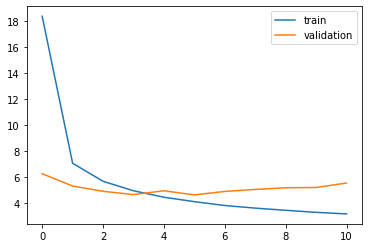

Repetition 5 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 41.2354 - val_loss: 4.9282

Epoch 00001: val_loss improved from inf to 4.92819, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_5/best_model_repitition_5.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 7.8733 - val_loss: 3.9811

Epoch 00002: val_loss improved from 4.92819 to 3.98108, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_5/best_model_repitition_5.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 6.1929 - val_loss: 3.4689

Epoch 00003: val_loss improved from 3.98108 to 3.46886, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition

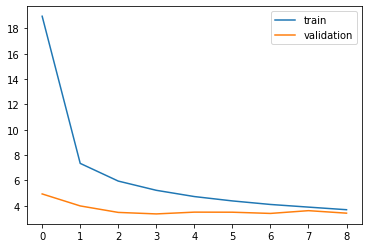

Repetition 6 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 40.5221 - val_loss: 3.7869

Epoch 00001: val_loss improved from inf to 3.78686, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_6/best_model_repitition_6.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 7.5640 - val_loss: 2.9592

Epoch 00002: val_loss improved from 3.78686 to 2.95919, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_6/best_model_repitition_6.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 5.9594 - val_loss: 3.0396

Epoch 00003: val_loss did not improve from 2.95919
Epoch 4/200
1229/1229 [==============================] - 64s 52ms/step - loss: 5.1192 - val_loss: 2.7056

Epoch 00004: val_loss improved from 2.

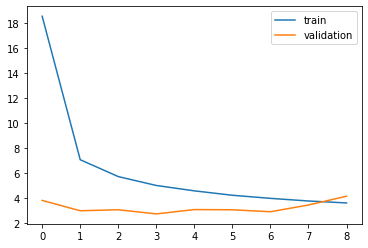

Repetition 7 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 34.5188 - val_loss: 5.9481

Epoch 00001: val_loss improved from inf to 5.94812, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_7/best_model_repitition_7.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 7.4119 - val_loss: 4.9145

Epoch 00002: val_loss improved from 5.94812 to 4.91453, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_7/best_model_repitition_7.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 5.8272 - val_loss: 4.5281

Epoch 00003: val_loss improved from 4.91453 to 4.52807, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition

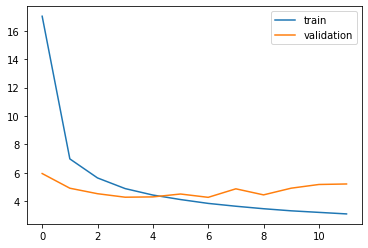

Repetition 8 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 35.8467 - val_loss: 6.8478

Epoch 00001: val_loss improved from inf to 6.84776, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_8/best_model_repitition_8.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 7.4212 - val_loss: 5.6258

Epoch 00002: val_loss improved from 6.84776 to 5.62577, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_8/best_model_repitition_8.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 5.8070 - val_loss: 5.1144

Epoch 00003: val_loss improved from 5.62577 to 5.11441, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition

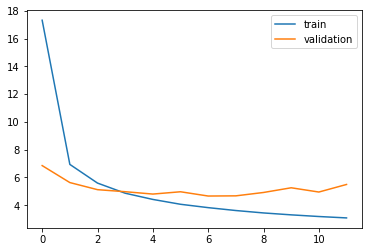

Repetition 9 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 47.1944 - val_loss: 5.3145

Epoch 00001: val_loss improved from inf to 5.31450, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_9/best_model_repitition_9.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 8.2000 - val_loss: 3.7879

Epoch 00002: val_loss improved from 5.31450 to 3.78795, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_9/best_model_repitition_9.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 6.2952 - val_loss: 3.3622

Epoch 00003: val_loss improved from 3.78795 to 3.36224, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition

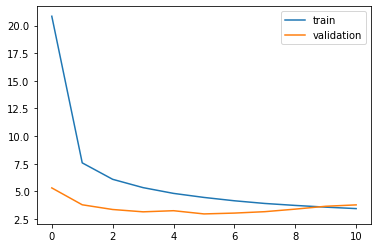

Repetition 10 model training started ...
Epoch 1/200
1229/1229 [==============================] - 65s 52ms/step - loss: 43.9426 - val_loss: 5.3313

Epoch 00001: val_loss improved from inf to 5.33127, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_10/best_model_repitition_10.h5
Epoch 2/200
1229/1229 [==============================] - 64s 52ms/step - loss: 7.6765 - val_loss: 4.1714

Epoch 00002: val_loss improved from 5.33127 to 4.17138, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repetition_10/best_model_repitition_10.h5
Epoch 3/200
1229/1229 [==============================] - 64s 52ms/step - loss: 6.1170 - val_loss: 3.6895

Epoch 00003: val_loss improved from 4.17138 to 3.68948, saving model to /scratch/groups/abrandt/solar_forecasting/dataset_open_source_project/model_output/SUNSET_nowcast_2017_2019_data/repet

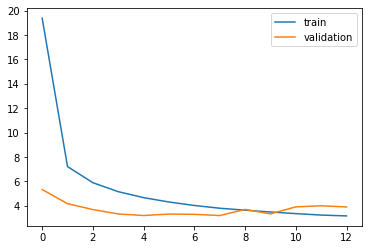

In [26]:
# generate dayblock shuffled indices
indices_dayblock_shuffled = day_block_shuffle(times_trainval)

# initialize loss history list
train_loss_hist = []
val_loss_hist = []
    
for i in range(num_fold):
    
    # construct and compile model for each repetition to reinitialize the model weights
    keras.backend.clear_session()
    model = sunset_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),loss='mse')
    
    # implementing 10-fold cross-validation
    print('Repetition {0} model training started ...'.format(i+1))
    
    # creating folder for saving model checkpoint
    save_directory = os.path.join(output_folder,'repetition_'+str(i+1))
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # training and validation data preparation
    ## generate indices dataset for training and validation
    indices_train, indices_val = cv_split(indices_dayblock_shuffled,i,num_fold)
    ## load data from dataloader
    ds_train_batched = data_loader(data_path,indices_train)
    ds_val_batched = data_loader(data_path,indices_val,batch_size=500)

    # define callbacks for training
    ## early stopping rule: if the validation loss stop decreasing for 5 consecutive epoches
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    ## model check point: save model checkpoint for later use
    checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(save_directory,'best_model_repitition_'+str(i+1)+'.h5'), 
                                monitor='val_loss', mode='min', save_best_only=True, verbose=1)

    # training the model and record training and validation loss
    history = model.fit(ds_train_batched, epochs=num_epochs, steps_per_epoch=len(indices_train)//batch_size+1,
                               verbose=1, callbacks=[earlystop,checkpoint], validation_data=ds_val_batched,
                              validation_steps=len(indices_val)//batch_size+1)
    train_loss_hist.append(history.history['loss'])
    val_loss_hist.append(history.history['val_loss'])
    
    # saving model training and validation loss history
    np.save(os.path.join(output_folder,'train_loss_hist.npy'),train_loss_hist)
    np.save(os.path.join(output_folder,'val_loss_hist.npy'),val_loss_hist)

    # plot training and validation history
    plt.plot(train_loss_hist[i],label='train')
    plt.plot(val_loss_hist[i],label='validation')
    plt.legend()
    plt.show()

In [27]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

Model 1  -- train loss: 1.97, validation loss: 2.26 (RMSE)
Model 2  -- train loss: 2.26, validation loss: 1.73 (RMSE)
Model 3  -- train loss: 2.13, validation loss: 2.05 (RMSE)
Model 4  -- train loss: 2.03, validation loss: 2.16 (RMSE)
Model 5  -- train loss: 2.28, validation loss: 1.83 (RMSE)
Model 6  -- train loss: 2.23, validation loss: 1.64 (RMSE)
Model 7  -- train loss: 1.96, validation loss: 2.07 (RMSE)
Model 8  -- train loss: 1.95, validation loss: 2.16 (RMSE)
Model 9  -- train loss: 2.11, validation loss: 1.72 (RMSE)
Model 10  -- train loss: 1.95, validation loss: 1.79 (RMSE)
The mean train loss (RMSE) for all models is 2.09
The mean validation loss (RMSE) for all models is 1.94


### Model testing

In [5]:
# load testing data
times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...]

# process image data
images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

times_test.shape: (14003,)
images_log_test.shape: (14003, 64, 64, 3)
pv_log_test.shape: (14003,)


In [8]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)
    
    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=images_log_test, y=pv_log_test, batch_size=200, verbose=1)
    
    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(images_log_test, batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction 
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

loading repetition 1 model ...
evaluating performance for the model
71/71 [==============================] - 7s 5ms/step - loss: 6.3024
generating predictions for the model
71/71 [==============================] - 0s 4ms/step
loading repetition 2 model ...
evaluating performance for the model
71/71 [==============================] - 0s 5ms/step - loss: 6.0628
generating predictions for the model
71/71 [==============================] - 0s 4ms/step
loading repetition 3 model ...
evaluating performance for the model
71/71 [==============================] - 1s 6ms/step - loss: 5.9357
generating predictions for the model
71/71 [==============================] - 0s 4ms/step
loading repetition 4 model ...
evaluating performance for the model
71/71 [==============================] - 0s 5ms/step - loss: 6.5834
generating predictions for the model
71/71 [==============================] - 0s 4ms/step
loading repetition 5 model ...
evaluating performance for the model
71/71 [=====================

In [9]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
prediction_ensemble_sunny = prediction_ensemble[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
prediction_ensemble_cloudy = prediction_ensemble[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

times_test_sunny.shape: (6986,)
times_test_cloudy.shape: (7017,)


In [10]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((prediction_ensemble_sunny-pv_log_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((prediction_ensemble_cloudy-pv_log_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_log_test_sunny)+rmse_cloudy**2*len(pv_log_test_cloudy))/(len(pv_log_test)))

print("test set sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("test set cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("test set overall RMSE: {0:.3f}".format(rmse_overall))

test set sunny days RMSE: 0.804
test set cloudy days RMSE: 3.335
test set overall RMSE: 2.428


In [11]:
# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((prediction_ensemble_sunny-pv_log_test_sunny)))
mae_cloudy = np.mean(np.abs((prediction_ensemble_cloudy-pv_log_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_log_test_cloudy) + mae_sunny*len(pv_log_test_sunny))/(len(pv_log_test))

print("test set sunny days MAE: {0:.3f}".format(mae_sunny))
print("test set cloudy days MAE: {0:.3f}".format(mae_cloudy))
print("test set overall MAE: {0:.3f}".format(mae_overall))

test set sunny days MAE: 0.657
test set cloudy days MAE: 2.337
test set overall MAE: 1.499


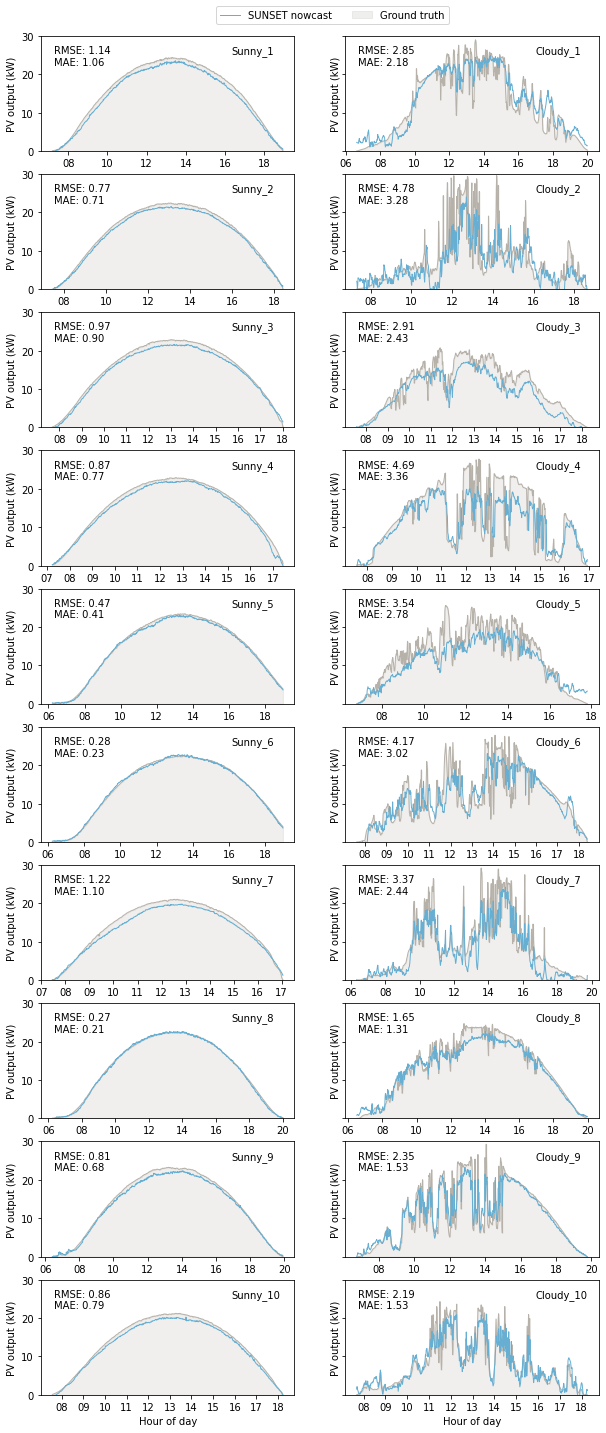

In [14]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

blue = '#67AFD2'
grey =  '#B6B1A9'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i,1]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

    
axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)    
plt.show()  